# Load packages

In [1]:
import pandas as pd
import re # regexes
from pathlib import Path # better way to work with filepaths

# Load in Data

In [2]:
# List all .txt files in data directory
# One file for each year of baby names in the US since late 1800s until 2018
baby_name_folder = Path.cwd() / "data" / "names"
baby_name_files = [x for x in baby_name_folder.glob('*txt')]
# Have a look at one file
baby_name_files[0]

WindowsPath('C:/Users/user457/Documents/udacity-data-scientist-nanodegree-project-1-write-a-data-science-blog-post/data/names/yob1880.txt')

In [3]:
def parse_raw_data(f):
    df = pd.read_csv(f, header = 0, names=['name','sex','babies'])
    # Add year from the filename
    # Data itself doesn't have the year, but the filename always has the pattern of yob{4-digit-Year}.txt
    df["year"] = int(re.search(r'\d\d\d\d', str(f), re.IGNORECASE).group(0))
    return(df)

# Map function to each file
baby_names_list = map(parse_raw_data, baby_name_files)
# Load all data into a single pandas dataframe
baby_names = pd.concat(baby_names_list)
baby_names.head()

,name,sex,babies,year
0,Anna,F,2604,1880
1,Emma,F,2003,1880
2,Elizabeth,F,1939,1880
3,Minnie,F,1746,1880
4,Margaret,F,1578,1880


# Exploratory data analysis 

### How many years of data do we have?

In [4]:
baby_names["year"].describe()

count    1.956907e+06
mean     1.975565e+03
std      3.419002e+01
min      1.880000e+03
25%      1.952000e+03
50%      1.985000e+03
75%      2.004000e+03
max      2.018000e+03
Name: year, dtype: float64

In [5]:
# Avoid scientific notation
# https://stackoverflow.com/questions/40347689/dataframe-describe-suppress-scientific-notation
baby_names["year"].describe().apply(lambda x: format(x, 'f'))

count    1956907.000000
mean        1975.564815
std           34.190022
min         1880.000000
25%         1952.000000
50%         1985.000000
75%         2004.000000
max         2018.000000
Name: year, dtype: object

In [6]:
baby_names['year'].nunique()

139

* 1880 to 2018, 139 years of data

### How has the US born population increased over the years - using baby names as a proxy?

In [7]:
baby_names.groupby('year')['babies'].sum()

year
1880     194419
1881     185777
1882     213385
1883     208932
1884     234244
         ...   
2014    3677978
2015    3671535
2016    3638301
2017    3542175
2018    3468665
Name: babies, Length: 139, dtype: int64

* We can see the huge growth over the decades. Remember, this is NOT the total US Population. In fact, it is the top 1000 names which represent > 70% of US baby names in the US for 2018 (latest year of data)

### Has the diversity (uniqueness) of baby names increased over the years?

In [8]:
baby_names.groupby('year')['name'].nunique()

year
1880     1889
1881     1830
1882     2012
1883     1962
1884     2158
        ...  
2014    30742
2015    30603
2016    30415
2017    30006
2018    29494
Name: name, Length: 139, dtype: int64

* Appears to be the case

### What first letter is the most popular in the US in the past few years?

In [38]:
baby_names['first_letter'] = baby_names['name'].str[0]
first_letters = baby_names.groupby(['year','first_letter']).agg({'babies':'sum'}).reset_index()
first_letters.head()


,year,first_letter,babies
0,1880,A,16740
1,1880,B,5991
2,1880,C,15817
3,1880,D,4706
4,1880,E,18338


In [41]:
# get dataframe sorted by baby names in each year
g = first_letters.groupby(["year"]).apply(lambda x: x.sort_values(["babies"], ascending = False)).reset_index(drop=True)
# select top N rows within each year
g.groupby('year').head(5)[g['year']>=2008]

C:\Users\user457\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,year,first_letter,babies
3303,2008,A,548561
3304,2008,J,466692
3305,2008,M,332027
3306,2008,C,288109
3307,2008,K,250422
3329,2009,A,533016
3330,2009,J,441518
3331,2009,M,317774
3332,2009,C,281708
3333,2009,K,240587


* Looks like A, J, and M have been consistently popular for the past decade

 https://www.washingtonpost.com/technology/2020/05/08/musk-grimes-baby-name/

### Elon Musk's baby name

* If you haven't heard, Elon and his girlfriend singer Grimes recently had a baby boy and they gave him a unique name:
X Æ A-12. However, the state of California only allows 26 english letters on the birth certificate. So I suspect
they may eventually have to give baby X a more traditional name. What would be some good options?

### X marks the spot

* X seems to be the first choice, going by Grandma's latest tweet - https://twitter.com/mayemusk/status/1259297517776171008


### So what were the most popular US baby names starting with X in the past decade?

In [102]:
elon_baby_X_RAW = baby_names[(baby_names['year']>=2008) & (baby_names['first_letter']=='X') & (baby_names['sex']=='M')]
#elon_baby_X_RAW.groupby('name')['babies'].sum().sort_values(ascending = False).head(10)
elon_baby_X = elon_baby_X_RAW.groupby('name')['babies'].sum().sort_values(ascending = False).reset_index()
#chance of being named if first letter chosen is X based on this frequency count
elon_baby_X['percent_total'] = 100 * (elon_baby_X['babies']/elon_baby_X['babies'].sum())
top_10_X = elon_baby_X.head(10)
top_10_X

,name,babies,percent_total
0,Xavier,56833,61.286705
1,Xander,19657,21.197416
2,Xzavier,4058,4.376004
3,Xavi,1747,1.883903
4,Xavion,992,1.069738
5,Xaiden,763,0.822792
6,Xavian,756,0.815244
7,Xavior,646,0.696624
8,Xayden,513,0.553201
9,Xzavion,508,0.547809


### A - Ash or Archangel or A...?


* Another strong possibility is a name would starts with A Could it be Ash or Archangel? What variants could we expect?
* **A** has been the most popular first letter for the past decade

In [92]:
elon_baby_A_RAW = baby_names[(baby_names['year']>=2008) & (baby_names['first_letter']=='A') & (baby_names['sex']=='M')]
#elon_baby_X_RAW.groupby('name')['babies'].sum().sort_values(ascending = False).head(10)
elon_baby_A = elon_baby_A_RAW.groupby('name')['babies'].sum().sort_values(ascending = False).reset_index()
#chance of being named if first letter chosen is A based on this frequency count
#elon_baby_A['percent_total'] = 100 * (elon_baby_A['babies']/elon_baby_A['babies'].sum())
elon_baby_A['percent_total'] = elon_baby_A['babies']/elon_baby_A['babies'].sum()
top_10_A = elon_baby_A.head(10)
top_10_A

,name,babies,percent_total
0,Alexander,167408,0.077220
1,Aiden,151534,0.069898
2,Anthony,138848,0.064046
3,Andrew,129570,0.059766
4,Aaron,81285,0.037494
5,Angel,78119,0.036034
6,Adrian,75646,0.034893
7,Austin,69839,0.032214
8,Adam,58142,0.026819
9,Ayden,56200,0.025923


* Angel is in the top 10, my bet is that could be the nickname for the official name of Archangel. This time the distribution is much more evenly distribute so no clear winner here. 

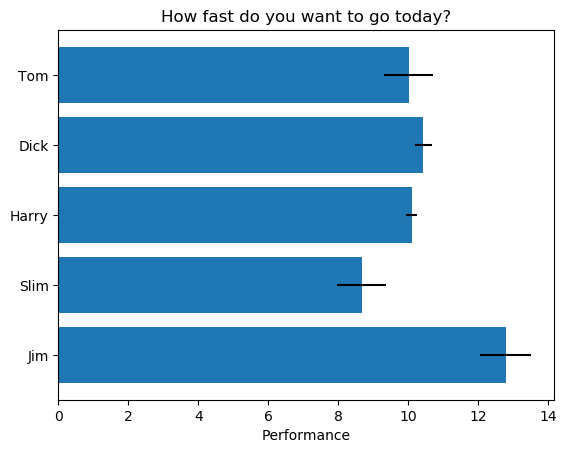

In [93]:
#https://matplotlib.org/3.2.1/gallery/lines_bars_and_markers/barh.html
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = ('Tom', 'Dick', 'Harry', 'Slim', 'Jim')
y_pos = np.arange(len(people))
performance = 3 + 10 * np.random.rand(len(people))
error = np.random.rand(len(people))

ax.barh(y_pos, performance, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('How fast do you want to go today?')

plt.show()

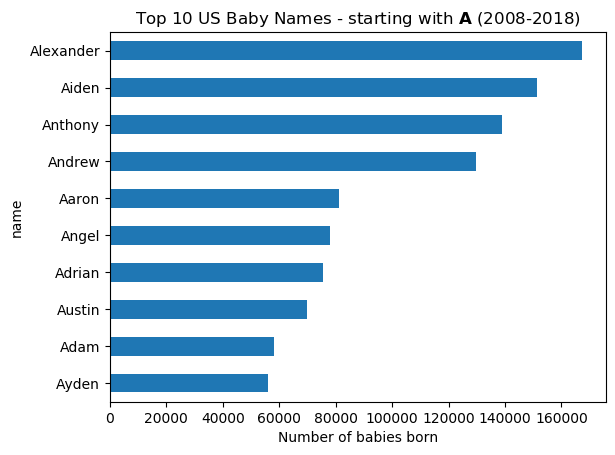

In [112]:
#ax = top_10_A.plot.barh(x='name', y='percent_total')
ax = top_10_A.plot.barh(x='name', y='babies')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of babies born')
ax.set_title('Top 10 US Baby Names - starting with '  + r"$\bf{" + " A " + "}$" + ' (2008-2018)')
#for i, v in enumerate(round(top_10_A['percent_total'], 0)):
#    ax.text(v + 0.5, i + .025, str(v), color='black', fontweight='bold')
#from matplotlib.ticker import FuncFormatter
#ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.get_legend().remove()
plt.show()

In [99]:
### Back to X names

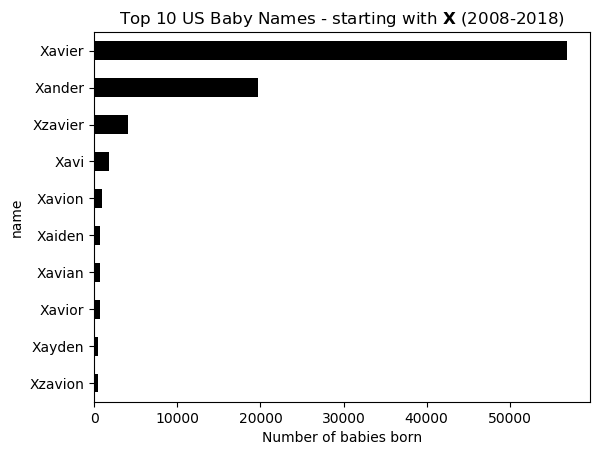

In [111]:
ax = top_10_X.plot.barh(x='name', y='babies', color='black')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of babies born')
ax.set_title('Top 10 US Baby Names - starting with '  + r"$\bf{" + " X " + "}$" + ' (2008-2018)')
ax.get_legend().remove()
plt.show()

In [ ]:
# Michael Jordan - Be Like Mike?

In [ ]:
# One more, current events, you may be watching the last dance with Michael Jordan. How popular did Mike>
# How many babies were born like Mike?

In [ ]:
# Where was the Mike baby boom? Illinois, North Carolina, or some other state?